# Offline hand-eye callibration

In [55]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json

from apriltag import apriltag

In [56]:
data_root = '../../../../../data/cobot/calibration/calibdata_2025_08_03-17_58_51'
calibration_config_file = '../../../handeye_calibration_params.json'

with open(calibration_config_file, 'r') as f:
    calibration_config = json.load(f)

In [33]:
def load_and_detect(frame_count, detector):
    with open(os.path.join(data_root, "frame_%04d.pkl" % frame_count), "rb") as input_file:
        frame = pickle.load(input_file)

    im = frame['image']
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    detections = detector.detect(gray)
    
    return frame, gray, detections
    
def show_detections(gray, detections, apriltag_family, show_legend=True, show_family=True):
    plt.imshow(gray, cmap='gray')
    if show_family:
        plt.text(5, 24, 'family: %s' % (apriltag_family), 
                color='red', fontsize=12, ha='left', va='bottom')

    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, detection in enumerate(detections):
        color = colors[i % len(colors)]
        plt.plot(detection['center'][0], detection['center'][1], color+'x')
        contour = detection['lb-rb-rt-lt']
        contour = np.vstack((contour, contour[0]))  # Close the contour
        plt.plot(contour[:, 0], contour[:, 1], color+'o-', label='id: %d' % detection['id'])
        for j in range(4):
            plt.text(contour[j, 0] - 5, contour[j, 1] - 5, '%d' % j, color=color, fontsize=12, ha='center', va='bottom')

    plt.axis('off')
    if show_legend:
        plt.legend(loc='upper right')

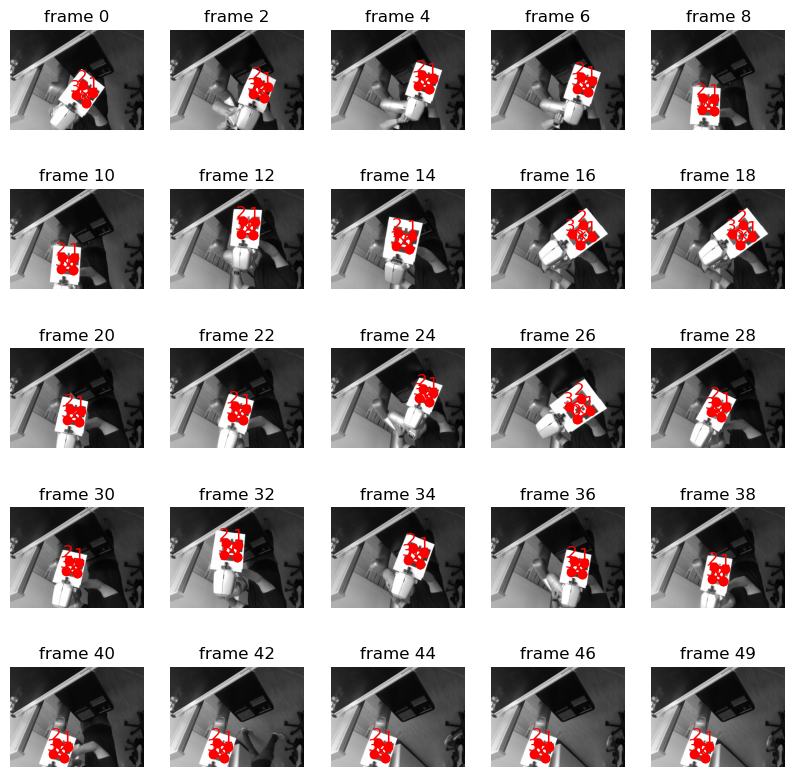

In [35]:
apriltag_family = 'tagStandard41h12'
detector = apriltag(apriltag_family)

plt.figure(figsize=(10, 10))
for i, frame_count in enumerate(np.linspace(0, 49, 25, dtype=int)):    
    frame, gray, detections = load_and_detect(frame_count, detector)

    plt.subplot(5, 5, i + 1)
    show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
    plt.title('frame %d' % frame_count)

In [36]:
frame_samples = [4, 10, 12, 14, 18, 22, 26, 30, 32, 34, 38]

In [ ]:
def quat2mat(q_wxyz):
    """ Calculate rotation matrix corresponding to quaternion.

    For reference, see https://github.com/matthew-brett/transforms3d/blob/main/transforms3d/quaternions.py
    
    Args:
        q_wxyz: 4 element quaternion, in order w, x, y, z.

    Returns:
        (3,3)-rotation matrix corresponding to input quaternion q_wxyz.

    Examples:
    
    >>> import numpy as np
    >>> M = quat2mat([1, 0, 0, 0]) # Identity quaternion
    >>> np.allclose(M, np.eye(3))
    True
    >>> M = quat2mat([0, 1, 0, 0]) # 180 degree rotn around axis 0
    >>> np.allclose(M, np.diag([1, -1, -1]))
    True
    """
    EPS = np.finfo(np.float64).eps
    w, x, y, z = q_wxyz
    Nq = w*w + x*x + y*y + z*z
    if Nq < EPS:
        return np.eye(3)
    s = 2.0/Nq
    X = x*s
    Y = y*s
    Z = z*s
    wX = w*X; wY = w*Y; wZ = w*Z
    xX = x*X; xY = x*Y; xZ = x*Z
    yY = y*Y; yZ = y*Z; zZ = z*Z
    return np.array(
           [[ 1.0-(yY+zZ), xY-wZ, xZ+wY ],
            [ xY+wZ, 1.0-(xX+zZ), yZ-wX ],
            [ xZ-wY, yZ+wX, 1.0-(xX+yY) ]])


def mat2quat(M):
    """ Calculate quaternion corresponding to given rotation matrix.
    
    For reference, see https://github.com/matthew-brett/transforms3d/blob/main/transforms3d/quaternions.py

    Args:
      M : 3x3 rotation matrix.

    Returns:
      Closest quaternion (w,x,y,z) to input matrix, having positive w.

    Examples:
    
    >>> import numpy as np
    >>> q = mat2quat(np.eye(3)) # Identity rotation
    >>> np.allclose(q, [1, 0, 0, 0])
    True
    >>> q = mat2quat(np.diag([1, -1, -1]))
    >>> np.allclose(q, [0, 1, 0, 0]) # 180 degree rotn around axis 0
    True
    """
    Qxx, Qyx, Qzx, Qxy, Qyy, Qzy, Qxz, Qyz, Qzz = M.flat
    K = np.array([
        [Qxx - Qyy - Qzz, 0,               0,               0              ],
        [Qyx + Qxy,       Qyy - Qxx - Qzz, 0,               0              ],
        [Qzx + Qxz,       Qzy + Qyz,       Qzz - Qxx - Qyy, 0              ],
        [Qyz - Qzy,       Qzx - Qxz,       Qxy - Qyx,       Qxx + Qyy + Qzz]]
        ) / 3.0
    vals, vecs = np.linalg.eigh(K)
    q = vecs[[3, 0, 1, 2], np.argmax(vals)]
    if q[0] < 0:
        q *= -1
    return q


In [ ]:
def extract_pose_from_detection(frame, detection, tagsize=0.074):
    objectPoints = np.array([
        [-tagsize / 2, -tagsize / 2, 0], # left bottom
        [+tagsize / 2, -tagsize / 2, 0], # right bottom
        [+tagsize / 2, +tagsize / 2, 0], # right top
        [-tagsize / 2, +tagsize / 2, 0], # left top
    ], dtype=np.float64)

    detection = detections[0]  # Assuming we are using the first detection
    imagePoints = detection['lb-rb-rt-lt']

    cameraMatrix = np.array(frame['camera_info']['k']).reshape((3, 3))
    distortion_coeffs = np.array(frame['camera_info']['d']).reshape((1, 5))

    retval, rvec, tvec = cv2.solvePnP(objectPoints, imagePoints, cameraMatrix, distortion_coeffs)
    assert retval, "Error: solvePnP failed"
    rmat, _ = cv2.Rodrigues(rvec)

    return rvec, tvec, rmat


tagsize = 0.074  # Size of the tag in meters

marker_camera_rot, marker_camera_tr = [], []
hand_world_rot, hand_world_tr = [], []

for frame_count in frame_samples:
    frame, gray, detections = load_and_detect(frame_count, detector)
    if not detections:
        print(f"No detections in frame {frame_count}")
        continue
    _, tvec_marker, rmat_marker = extract_pose_from_detection(frame, detections[0], tagsize)
    marker_camera_rot.append(rmat_marker)
    marker_camera_tr.append(tvec_marker)

    tvec_robot = np.array([frame['robot_transform']['translation']['x'], 
                           frame['robot_transform']['translation']['y'], 
                           frame['robot_transform']['translation']['z']]).reshape((3, 1))
    quat_wxyz_robot = np.array([frame['robot_transform']['rotation']['w'], 
                                frame['robot_transform']['rotation']['x'], 
                                frame['robot_transform']['rotation']['y'], 
                                frame['robot_transform']['rotation']['z']])
    rmat_robot = quat2mat(quat_wxyz_robot)
    hand_world_rot.append(rmat_robot)
    hand_world_tr.append(tvec_robot)
    
method = cv2.CALIB_HAND_EYE_TSAI
hand_camera_rot, hand_camera_tr = cv2.calibrateHandEye(hand_world_rot, hand_world_tr, 
                                                       marker_camera_rot, marker_camera_tr, method=method)
hand_camera_qwxyz = mat2quat(hand_camera_rot)

print("Hand-Eye Calibration Results:")
print("Rotation Matrix:")
print(hand_camera_rot)
print("Quaternion (wxyz):")
print(hand_camera_qwxyz)
print("Translation Vector:")
print(hand_camera_tr)

# result = Transform(translation=Vector3(x=hctx, y=hcty, z=hctz),
#                           rotation=Quaternion(x=hcqx, y=hcqy, z=hcqz, w=hcqw))

Hand-Eye Calibration Results:
Rotation Matrix:
[[ 0.79656384  0.59758495  0.09153292]
 [-0.5737319   0.69950991  0.4260488 ]
 [ 0.19057217 -0.39189043  0.90005785]]
Quaternion (wxyz):
[ 0.92142981 -0.2219212  -0.02687108 -0.31779872]
Translation Vector:
[[-0.31702378]
 [ 0.28075497]
 [ 1.11076064]]


In [60]:
def save_calibration(filename, calibration_config, hand_camera_qwxyz, hand_camera_tr):
    config = {
        'calibration_type': calibration_config['calibration_type'],
        'robot_base_frame': calibration_config['robot_base_frame'],
        'robot_effector_frame': calibration_config['robot_effector_frame'],
        'tracking_base_frame': calibration_config['tracking_base_frame'],
        'translation': hand_camera_tr.tolist(),
        'rotation_q_wxyz': hand_camera_qwxyz.tolist()
    }
    with open(filename, 'w') as f:
        json.dump(config, f, indent=2)
    

def load_calibration(filename):
    with open(filename, 'r') as f:
        config = json.load(f)
    return config


calibration_file = '../../../handeye_calibration.json'
save_calibration(calibration_file, calibration_config, hand_camera_qwxyz, hand_camera_tr)

loaded_calibration = load_calibration(calibration_file)
print("Loaded Calibration:")
print(loaded_calibration)   

Loaded Calibration:
{'calibration_type': 'eye_on_base', 'robot_base_frame': 'base_link', 'robot_effector_frame': 'TCP', 'tracking_base_frame': 'camera_color_optical_frame', 'translation': [[-0.31702377983908586], [0.28075497185685033], [1.1107606447876142]], 'rotation_q_wxyz': [0.921429813660923, -0.22192119780855224, -0.026871077642111656, -0.3177987187613663]}
